# Análisis de los datos recopilados durante el Experimento 1

Dentro de este experimento se busca validar las ideas de arquitectura relacionadas con  la implementacion de la táctica de _Recuperación de Fallas_  para favorecer  la disponibilidad a traves de la estrategía de _Retry_ o reintento, por otro lado hemos implementado escalamiento horizontal al agregar 2 instancias más del *microservicio de inventario*. Se ha configurado nginx como API Gateway, donde se realiza hasta un máximo de 5 reintentos de la petición en caso de que la petición falle 5 veces se retorna un error 500 al cliente.

Para mockear el comportamiento del microservicio de inventario bajo fallas, se ha configurado una tasa de éxito del 75% para las peticiones, es decir, en un 25% de las ocasiones el microservicio retornará un error 500.

Esto se hace escogiendo un número aleatorio entre 1 y 100 y si este es menor o igual a 25 se retorna un error 500.

###  Datos a analizar

*id* - Un valor uuid que identifica de forma única a cada petición.


*start* - La fecha y hora en la que se realizó la petición.


*end* - La fecha y hora en la que se recibió la respuesta.


*delta* - Tiempo de procesamiento en milisegundos.


*status* - El estado de la petición, si fue procesada correctamente o no. (True/False)

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Cargar los datos de ambas pruebas

In [28]:
input_no_retry = pd.read_csv("input_sin.csv",  names=['id', 'start', 'end', 'delta', 'status'])
responses_no_retry = pd.read_csv("response_sin.csv",  names=['id', 'start', 'end', 'delta', 'status'])

input_retry = pd.read_csv("input.csv",  names=['id', 'start', 'end', 'delta', 'status'])
responses_retry = pd.read_csv("responses.csv",  names=['id', 'start', 'end', 'delta', 'status'])

#### Asi se verían los datos

In [29]:
input_no_retry.head()

,id,start,end,delta,status
0,a0436df9-1ce3-49c7-a42c-2f0c519ff618,2025-02-23T23:31:37.373848,2025-02-23T23:31:37.387394,13546,True
1,8c1e7451-1107-49ea-9d29-9bb5877bdf09,2025-02-23T23:31:37.788663,2025-02-23T23:31:37.798862,10199,True
2,0f53e0d0-8f8c-4bcc-b27a-394468839d97,2025-02-23T23:31:38.199681,2025-02-23T23:31:38.212426,12745,True
3,b93fc74e-a5ff-4897-ac81-d3e72fbf493b,2025-02-23T23:31:38.613524,2025-02-23T23:31:38.623720,10196,False
4,c24c448c-5bb9-48a1-b90c-220126c8bddf,2025-02-23T23:31:39.024548,2025-02-23T23:31:39.034482,9934,False


In [30]:
# Show the number of requests sent and received with and without retry

sent = len(input_no_retry)
received = len(responses_no_retry)

print(f"Requests sent without retry: {sent}")
print(f"Requests received without retry: {received}")

sent_retry = len(input_retry)
received_retry = len(responses_retry)

print(f"Requests sent with retry: {sent_retry}")
print(f"Requests received with retry: {received_retry}")

Requests sent without retry: 300
Requests received without retry: 300
Requests sent with retry: 300
Requests received with retry: 397


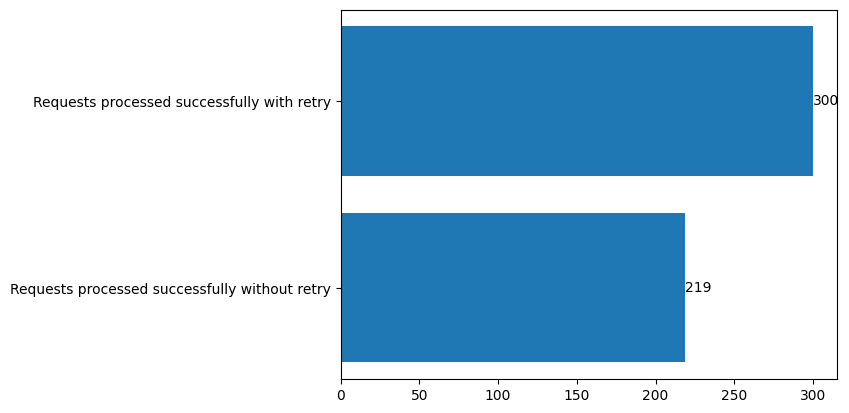

In [31]:
processed_no_retry = len(responses_no_retry[responses_no_retry['status'] == True])
processed_retry = len(responses_retry[responses_retry['status'] == True])

bars = plt.barh(['Requests processed successfully without retry', 'Requests processed successfully with retry'], [processed_no_retry, processed_retry])
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2.,
             f'{int(width)}',
             ha='left', va='center')
plt.show()

#### Podemos observar que el numero de peticiones procesadas correctamente es mayor con el retry, lo cual es lo que se busca demostrar con este experimento.

## Solicitudes totales generadas vs recibidas

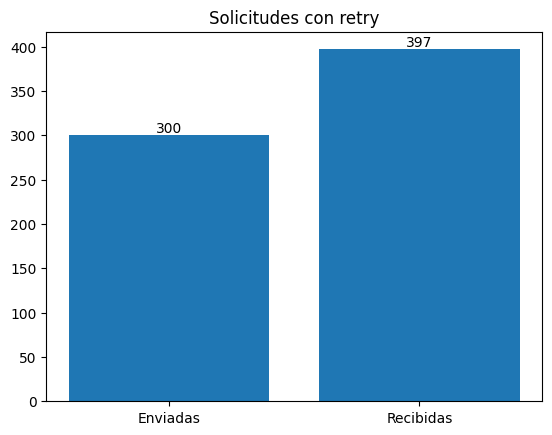

In [32]:
# Show total requests sent and received with retry in a bar chart
total_sent_retry = len(input_retry)
total_received_retry = len(responses_retry)

plt.figure()
bars = plt.bar(['Enviadas', 'Recibidas'], [total_sent_retry, total_received_retry])
plt.title('Solicitudes con retry')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom')
plt.show()


#### La gráfica de arriba nos muestra que el microservicio de inventario procesó 397 peticiones generadas por la app del cliente. Esto quiere decir que hubo 97 peticiones que fueron reintentadas. 

## Medir los reintentos de las peticiones

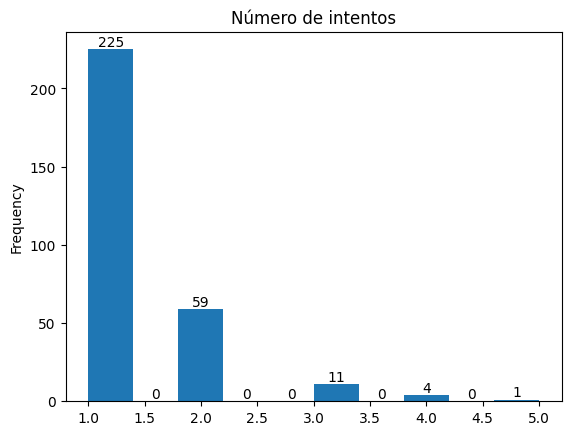

In [33]:
retries = responses_retry.groupby('id').size().reset_index(name='retries')
ax = retries.plot(kind='hist', title='Número de intentos', legend=False)

# Add labels to each bar
for rect in ax.patches:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., height,
            f'{int(height)}',
            ha='center', va='bottom')


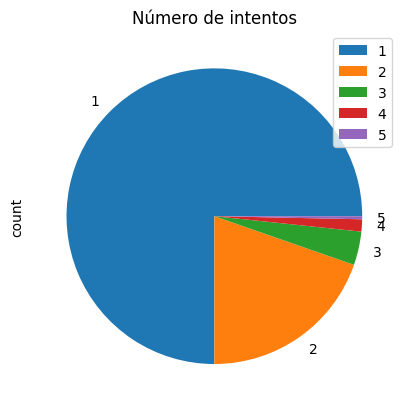

In [34]:
# Now make a pie chart of the number of retries
plt.figure()
retries['retries'].value_counts().plot(kind='pie', title='Número de intentos', legend=True)
plt.show()


## Concluyendo el experimento

##### Como el bodeguero cuando solicite el inventario de un producto dado que el sistema está en operación normal con fallas de comunicación quiero obtener una respuesta sobre la cantidad de elementos de ese producto para tener un conteo de este. Este debe suceder el 99.95% de las veces.

In [35]:
# Calculate the percentage of successful requests
percentage_success = processed_retry / total_sent_retry
print(f"Porcentaje de éxitos: {percentage_success:.2%}")

Porcentaje de éxitos: 100.00%


### Como se puede observar, haciendo uso de la táctica de _Recuperación de Fallas_ y el escalamiento horizontal, se logra un 100% de éxitos en las peticiones, lo cual es un resultado excelente.

Por ende, se puede concluir que el experimento fue exitoso y se cumple con la medida de la historia de arquitectura.